# **Nestle HR ChatBot**                   

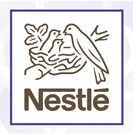

Author : Manohari Wijesooriya

Date   : Dec 08, 2024

# Project Goal

To create an intelligent HR Chatbot that provides accurate and user-friendly responses to HR-related inquiries based on Nestlé's HR policies and procedures.

# Scope and Requirements

* Identify the key HR-related topics (e.g., leave policies, benefits, onboarding, grievance redressal).
* Understand the chatbot’s user base (employees, HR team, new hires, etc.).
* Define the chatbot's tone (formal, friendly, etc.).


In [1]:
!pip install tiktoken PyPDF2 openai gradio chromadb pysqlite3-binary pypdf langchain langchain-community --upgrade --use-feature=fast-deps

Defaulting to user installation because normal site-packages is not writeable


In [2]:
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings, OpenAIEmbeddings
from langchain.vectorstores import Chroma
import pysqlite3
import sys
sys.modules["sqlite3"] = sys.modules.pop("pysqlite3")
import chromadb
import openai
import os
from langchain.chains.question_answering import load_qa_chain
from langchain.prompts import PromptTemplate
from langchain.chat_models import ChatOpenAI
import openai
import gradio as gr

In [12]:
#import openai
#openai.api_key = "voc-730917260112272230113166a5077cac4479.92242159"
#print(openai.api_key)

voc-730917260112272230113166a5077cac4479.92242159


# Data Preparation

* Collect Nestlé's HR policy documents, FAQs, and other relevant resources.
* Ensure documents are clean, well-structured, and up-to-date.


In [3]:
#import os
# Get the current working directory
current_path = os.getcwd()
print("Current working directory:", current_path)

Current working directory: /voc/work/Project1


In [12]:
#Reading HR policy document
loader = PyPDFLoader(r"/voc/work/Project1/1728286846_the_nestle_hr_policy_pdf_2012.pdf")

# Data Processing

* Import necessary libraries and tools (e.g., PyPDFLoader for PDFs, OpenAI API for embeddings).
* Preprocess and split the documents into smaller, meaningful chunks for embedding and retrieval.


In [13]:
# Split document into chunks
pages = loader.load_and_split()
len(pages)

8

In [14]:
# Print the last chunk (if chunks are used)
print(f"Last chunk of text:\n{pages[7].page_content}")

Last chunk of text:
The Nestlé Human Resources Policy
5
Since its founding, Nestlé has built a culture 
based on values of trust, mutual respect and 
dialogue. Nestlé management and employees all 
over the world work daily to create and maintain 
positive individual and collective relationships, 
and are expected to do so as a core part of their 
job.
Nestlé not only upholds the freedom of 
association of its employees and the effective 
recognition of the right to collective bargaining, 
but also ensures that direct and frequent 
communication is established in the workplace. 
While dialogue with trade unions is essential, it 
does not replace the close relationship that our 
management maintains with all employees.
In the spirit of continuous improvement, we 
encourage two-way dialogue with our employees 
that goes beyond the traditional aspects of 
collective bargaining in order to share knowledge 
and to jointly find opportunities related to 
important matters such as Creating Shar

In [15]:
# Use a text splitter for better chunking
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
documents = text_splitter.split_documents(pages)

# Display total chunks
print(f"Total chunks: {len(documents)}")

Total chunks: 21


In [16]:
# Initialize ChromaDB for persistent storage
client = chromadb.PersistentClient(path=r"/voc/work/Project1/ChromaDB\Nestle_Chatbot")

# Embeddings and Vector Store

* Create vector representations of the HR documents using OpenAI's embeddings.
* Store embeddings in a vector database like ChromaDB or Pinecone for efficient retrieval.


In [17]:
!pip install --upgrade openai langchain-openai
from langchain_openai import OpenAIEmbeddings

Defaulting to user installation because normal site-packages is not writeable


In [10]:
import os
#from langchain.embeddings.openai import OpenAIEmbeddings

os.environ["OPENAI_API_KEY"] = "voc-730917260112272230113166a5077cac4479.92242159"

In [18]:
#Create Vector Store for Text Embeddings
# Initialize OpenAI embeddings
embeddings = OpenAIEmbeddings()

# Use Chroma for storing embeddings
chroma_db = Chroma.from_documents(documents, embeddings) #vectorstore


In [23]:
search_result = chroma_db.similarity_search_with_score("What is the candidate's skill sets?", k=2)
print(search_result)  # Prints the top 2 most similar documents to the query

[(Document(metadata={'page': 3, 'source': '/voc/work/Project1/1728286846_the_nestle_hr_policy_pdf_2012.pdf'}, page_content='Only relevant skills and experience and \nadherence to the Nestlé principles will \nbe considered in employing a person. No \nconsideration will be given to a candidate’s origin, \nnationality, religion, race, gender, disability, sexual \norientation or age.\nWhilst adequate recruitment tools may \nimprove the hiring process, the decision to hire a \ncandidate remains in the hands of the responsible \nmanager, supported by the HR team. \n Joining Nestlé'), 0.39040276408195496), (Document(metadata={'page': 3, 'source': '/voc/work/Project1/1728286846_the_nestle_hr_policy_pdf_2012.pdf'}, page_content='Only relevant skills and experience and \nadherence to the Nestlé principles will \nbe considered in employing a person. No \nconsideration will be given to a candidate’s origin, \nnationality, religion, race, gender, disability, sexual \norientation or age.\nWhilst ade

In [26]:
# Load GPT-3.5 Turbo model
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)

# Define a custom prompt template
prompt_template = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an HR chatbot for Nestlé. Use the provided context to answer the question accurately and succinctly.

Context: {context}

Question: {question}

Answer:"""
)

# Update the QA chain to use the custom prompt
qa_chain = load_qa_chain(llm, chain_type="stuff", prompt=prompt_template)


In [38]:
def chatbot(query):
    try:
        # Search for relevant chunks in the vector store
        docs = chroma_db.similarity_search(query, k=4)
    
        # Combine chunks into context
        context = " ".join([doc.page_content for doc in docs])
        
        # Perform similarity search and get the answer
        answer = qa_chain.run({"input_documents": docs, "question": query})
        return answer
    except Exception as e:
        return f"An error occurred: {str(e)}"

In [39]:
# Build Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("### Nestlé HR Chatbot")
    query = gr.Textbox(label="Ask your HR question")
    output = gr.Textbox(label="Chatbot Response")
    submit_btn = gr.Button("Submit")
    submit_btn.click(fn=chatbot, inputs=query, outputs=output)

# Launch the Gradio app
demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7864
* Running on public URL: https://e9f8432e015033a5ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Questions 

What is Nestle's sick leave policy?

What strategies does Nestlé implement to nurture and develop employee talent?

How does Nestle in the Market process streamline HR functions, and what are the three areas of specilization within the HR structure?

What criterea does Nestle consider when hiring new employees?

How many company holidays are there in 2012?



In [40]:
demo.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
* Running on public URL: https://e9f8432e015033a5ce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
